In [67]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import statsmodels.api as sm
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('D:\\data\\21.07_BMW미팅\\df_data\\07.17_21_월별_6브랜드_판매량.csv', encoding='utf-8')
df

,Unnamed: 0,브랜드,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,...,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01
0,0,bmw,2415,3202,6164,6334,5373,5510,3188,4105,...,7252,5275,5320,5551,5749,5717,5660,6012,6113,6257
1,1,benz,6848,5534,6737,5758,5063,7783,5471,5267,...,6030,5958,6576,7186,9546,5918,5707,7597,8430,7690
2,2,audi,474,360,83,0,2,0,0,0,...,2022,2528,2527,2906,3109,2302,2362,2737,1320,229
3,3,volkswagen,0,0,0,0,0,0,0,0,...,881,872,1933,2677,2729,1236,1783,1628,1080,1358
4,4,mini,541,582,624,743,1013,841,794,826,...,1107,1108,890,940,1093,712,895,1224,1051,1095
5,5,volvo,436,570,675,542,596,693,624,602,...,336,801,1449,1267,1352,1198,1202,1251,1263,1264


In [12]:
df = df.drop(['Unnamed: 0'],axis=1)

In [28]:
bmw = df.loc[0]
bmw = bmw.reset_index()

In [19]:
benz = df.loc[1]
benz =benz.reset_index()

In [15]:
df2 = df.stack()

In [17]:
df2.reset_index()

,level_0,level_1,0
0,0,브랜드,bmw
1,0,2017-01-01,2415
2,0,2017-02-01,3202
3,0,2017-03-01,6164
4,0,2017-04-01,6334
...,...,...,...
319,5,2021-01-01,1198
320,5,2021-02-01,1202
321,5,2021-03-01,1251
322,5,2021-04-01,1263


In [34]:
result = pd.merge(bmw, benz, on=['index'], how='outer')
result

,index,0,1
0,브랜드,bmw,benz
1,2017-01-01,2415,6848
2,2017-02-01,3202,5534
3,2017-03-01,6164,6737
4,2017-04-01,6334,5758
5,2017-05-01,5373,5063
6,2017-06-01,5510,7783
7,2017-07-01,3188,5471
8,2017-08-01,4105,5267
9,2017-09-01,5299,5606


In [36]:
result.columns = ['year','BMW','Benz']

In [37]:
result = result.drop(index=[0], axis=0)
result

,year,BMW,Benz
1,2017-01-01,2415,6848
2,2017-02-01,3202,5534
3,2017-03-01,6164,6737
4,2017-04-01,6334,5758
5,2017-05-01,5373,5063
6,2017-06-01,5510,7783
7,2017-07-01,3188,5471
8,2017-08-01,4105,5267
9,2017-09-01,5299,5606
10,2017-10-01,4400,4539


In [99]:
# 데이터타입 바꾸기
result = result.astype({'BMW':'int'})
result = result.astype({'Benz':'int'})

In [45]:
# transacted_date, transacted_time 데이터 타입 string으로 인식하여 datetime64로 변환(column.dt.시간단위를 통해서 원하는 시간 부분을 추출해서 활용할 수 있음)
result['year'] = pd.to_datetime(result['year'])

KeyError: 'year'

In [46]:
result

,BMW,Benz
year,,
2017-01-01,2415,6848
2017-02-01,3202,5534
2017-03-01,6164,6737
2017-04-01,6334,5758
2017-05-01,5373,5063
2017-06-01,5510,7783
2017-07-01,3188,5471
2017-08-01,4105,5267
2017-09-01,5299,5606


In [64]:
#인덱스를 연도로 재설정
result.index = result['year']
result.set_index('year', inplace=True)
result.head()

,BMW,Benz
year,,
2017-01-01,2415,6848
2017-02-01,3202,5534
2017-03-01,6164,6737
2017-04-01,6334,5758
2017-05-01,5373,5063


<AxesSubplot:xlabel='year'>

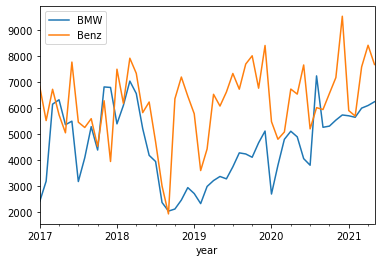

In [43]:
result.plot()

In [50]:
result = result.reset_index()

In [52]:
result

,year,BMW,Benz
0,2017-01-01,2415,6848
1,2017-02-01,3202,5534
2,2017-03-01,6164,6737
3,2017-04-01,6334,5758
4,2017-05-01,5373,5063
5,2017-06-01,5510,7783
6,2017-07-01,3188,5471
7,2017-08-01,4105,5267
8,2017-09-01,5299,5606
9,2017-10-01,4400,4539


<AxesSubplot:>

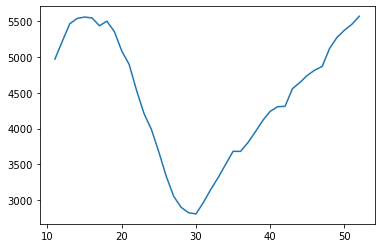

In [58]:
# BMW stationary 확인
timeseries = result['BMW']
timeseries.rolling(12).mean().plot()#12개월평균

<AxesSubplot:>

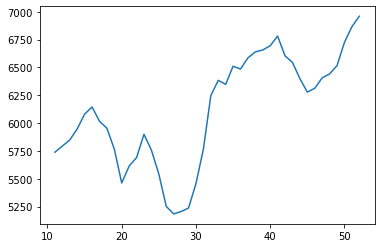

In [59]:
# Benz stationary 확인
timeseries = result['Benz']
timeseries.rolling(12).mean().plot()#12개월평균

In [65]:
decomposition = seasonal_decompose(result['BMW'], model='additive', extrapolate_trend='freq')

<Figure size 432x288 with 0 Axes>

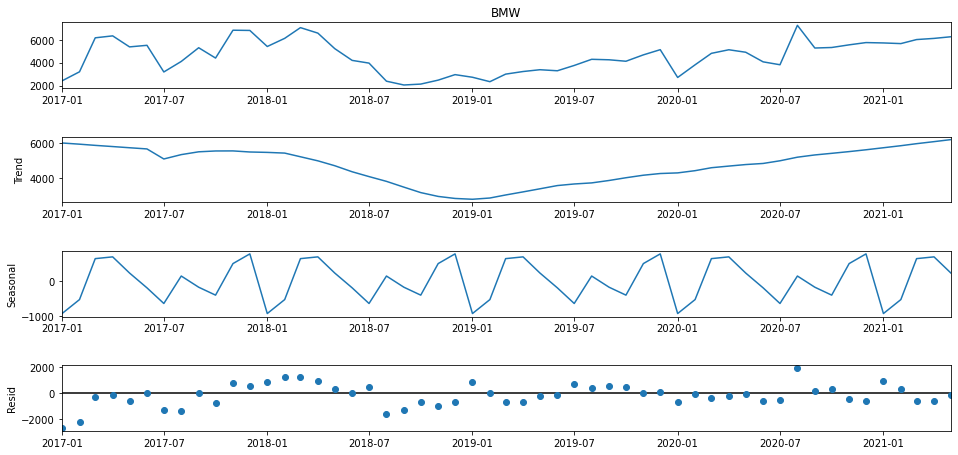

In [68]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,7)

<Figure size 432x288 with 0 Axes>

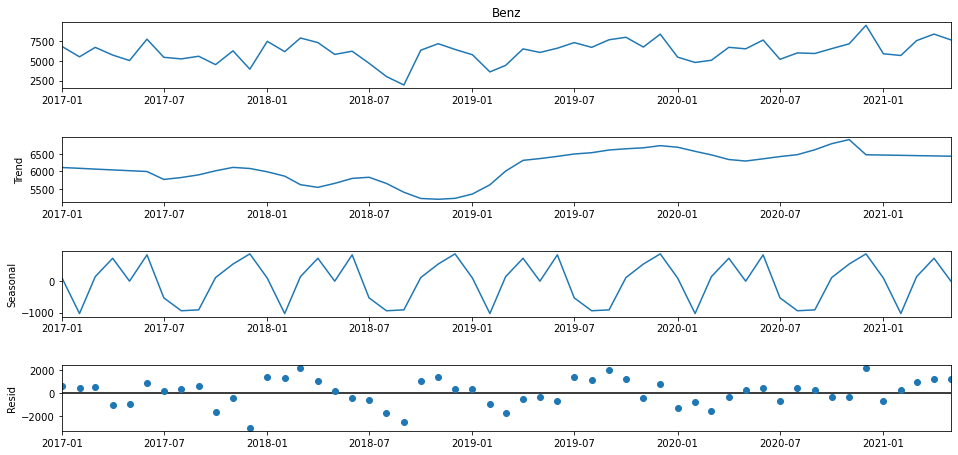

In [69]:
decomposition2 = seasonal_decompose(result['Benz'], model='additive', extrapolate_trend='freq')
fig = plt.figure()
fig = decomposition2.plot()
fig.set_size_inches(15,7)

In [ ]:
## stationary 검증 방법 ##

In [70]:
from statsmodels.tsa.stattools import adfuller

In [71]:
result2 = adfuller(result['BMW'])
result2

(-3.0147427042140813,
 0.03354036669069438,
 0,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 676.2432252758988)

In [76]:
#p-vslue 값이 0.03으로 정산성 확인
# stationary check 기능 함수
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <=0.05:
        print('Stationary{}'.format(result[1]))
    else:
        print('Non-stationary {}'.format(result[1]))

In [77]:
adf_check(result['BMW'])#정상성 획득

Stationary0.03354036669069438


In [78]:
result3 = adfuller(result['Benz'])
result3

(-4.895045858582145,
 3.565704715955595e-05,
 0,
 52,
 {'1%': -3.562878534649522,
  '5%': -2.918973284023669,
  '10%': -2.597393446745562},
 711.1101728738929)

## differencing ##

In [79]:
result['1st diff'] = result['Benz'] - result['Benz'].shift(1)
result.head()

,BMW,Benz,1st diff
year,,,
2017-01-01,2415,6848,NaN
2017-02-01,3202,5534,-1314
2017-03-01,6164,6737,1203
2017-04-01,6334,5758,-979
2017-05-01,5373,5063,-695


In [80]:
adf_check(result['1st diff'].dropna())

Stationary1.002382106464712e-05


<AxesSubplot:xlabel='year'>

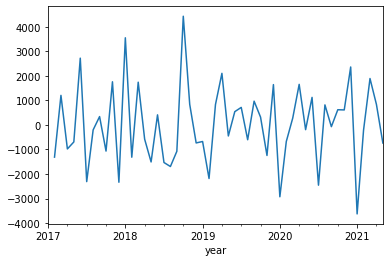

In [81]:
result['1st diff'].plot()

In [82]:
# d값은 1차 differencing이므로 1를 씀
# d = 1, D = 1

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

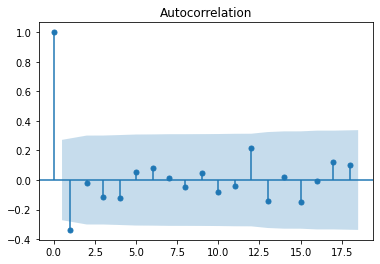

In [84]:
plot_acf(result['1st diff'].dropna());

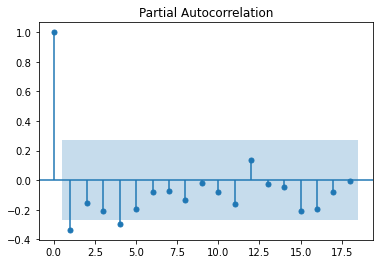

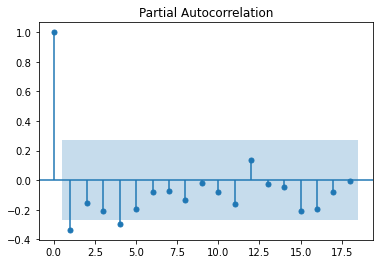

In [85]:
plot_pacf(result['1st diff'].dropna(), method='ywm')#partial AutoCorrelation

In [86]:
# acf에서 음수 1개씩 나왔으므로 p, q값은 각 P=1. Q=1씀

## 하이퍼 파라미터 정하기

In [94]:
!pip install pmdarima

  Using cached pmdarima-1.8.2-cp38-cp38-win_amd64.whl (596 kB)


In [95]:
# auto_arima 함수로 자동 추출
from pmdarima import auto_arima
stepwise_model = auto_arima(result['Benz'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=718.166, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=717.817, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=714.983, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=717.790, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=715.283, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=716.936, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=716.269, Time=0.05 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=717.034, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit

In [98]:
result['Benz']

year
2017-01-01    6848
2017-02-01    5534
2017-03-01    6737
2017-04-01    5758
2017-05-01    5063
2017-06-01    7783
2017-07-01    5471
2017-08-01    5267
2017-09-01    5606
2017-10-01    4539
2017-11-01    6296
2017-12-01    3959
2018-01-01    7509
2018-02-01    6192
2018-03-01    7932
2018-04-01    7349
2018-05-01    5839
2018-06-01    6248
2018-07-01    4715
2018-08-01    3019
2018-09-01    1943
2018-10-01    6371
2018-11-01    7208
2018-12-01    6473
2019-01-01    5796
2019-02-01    3611
2019-03-01    4442
2019-04-01    6543
2019-05-01    6092
2019-06-01    6632
2019-07-01    7345
2019-08-01    6740
2019-09-01    7707
2019-10-01    8025
2019-11-01    6779
2019-12-01    8421
2020-01-01    5492
2020-02-01    4815
2020-03-01    5093
2020-04-01    6745
2020-05-01    6551
2020-06-01    7672
2020-07-01    5215
2020-08-01    6030
2020-09-01    5958
2020-10-01    6576
2020-11-01    7186
2020-12-01    9546
2021-01-01    5918
2021-02-01    5707
2021-03-01    7597
2021-04-01    8430
2021-05

## 학습 및 검증

In [100]:
model = ARIMA(result['Benz'], order=(0,1,1))

In [101]:
mresult= model.fit(trend='c', full_output=True, disp=True)

In [102]:
mresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.Benz   No. Observations:                   52
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -450.618
Method:                       css-mle   S.D. of innovations           1351.060
Date:                Thu, 15 Jul 2021   AIC                            907.236
Time:                        17:15:49   BIC                            913.090
Sample:                    02-01-2017   HQIC                           909.480
                         - 05-01-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           27.3582     12.132      2.255      0.024       3.581      51.136
ma.L1.D.Benz    -0.9999      0.074    -13.529      0.000      -1.145      -0.855
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='year'>

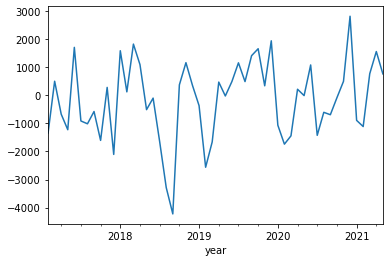

In [103]:
mresult.resid.plot()

<AxesSubplot:ylabel='Density'>

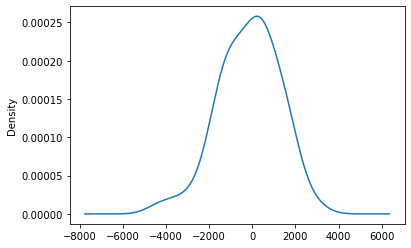

In [104]:
mresult.resid.plot(kind='kde')

## FC

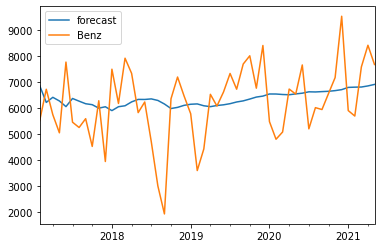

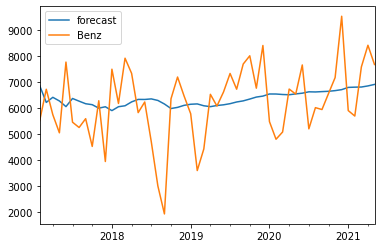

In [105]:
mresult.plot_predict()

In [110]:
# Forecast
fc, se, conf  = mresult.forecast(steps=7, alpha=0.05)
# 예측값, stderr, upper bound, lower bound 

In [111]:
# Make as pandas series
fc_series = pd.Series(fc, index=[54,55,56,57,58,59,60])
fc_series

54    6950.911373
55    6978.269556
56    7005.627739
57    7032.985922
58    7060.344104
59    7087.702287
60    7115.060470
dtype: float64

TypeError: float() argument must be a string or a number, not 'ARIMAResultsWrapper'

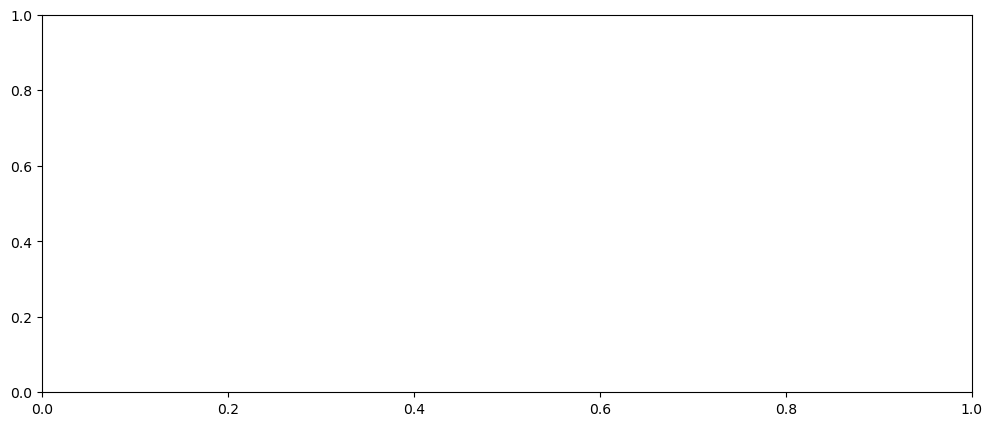

In [113]:
# plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)

plt.title('Forecast')
plt.legend(loc='upper right', fontsize=8)
plt.show()